### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torchsummary import summary
import math
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import re
from skimage.metrics  import structural_similarity as ssim

from importlib import reload
import visualization

# locals
import model_architectures

reload(model_architectures)
from model_architectures import VAESegment, Data3DSegT2, SegMaskData

reload(visualization)
from visualization import brain_diff, viz_slices

C:\compute\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Paths

In [2]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
model_dir = os.path.join(code_dir, "explore_again", "models")
data_dir = os.path.join(research_dir, "data")
dhcp_rel2 = os.path.join(data_dir, "dhcp_rel2")
processed_dir = os.path.join(dhcp_rel2, "processed")
volume_dir = os.path.join(processed_dir, "volumes")
seg_dir = os.path.join(processed_dir, "segments")
seg_vol_dir = os.path.join(processed_dir, "volume_segments")
pred_dir = os.path.join(dhcp_rel2, "predictions")
seg_pred_dir = os.path.join(pred_dir, "vae_9seg")

l1_dir = os.path.join(volume_dir, "l1")
l5_dir = os.path.join(volume_dir, "l5")

l1_seg_dir = os.path.join(seg_dir, "l1")
l5_seg_dir = os.path.join(seg_dir, "l5")

l1_seg_vol_dir = os.path.join(seg_vol_dir, "l1")
l5_seg_vol_dir = os.path.join(seg_vol_dir, "l5")

l1_seg_pred_dir = os.path.join(seg_pred_dir, "l1")
l5_seg_pred_dir = os.path.join(seg_pred_dir, "l5")

In [3]:
def exclude_segments(seg, indices):
    seg_slice = seg.copy()
    seg_slice[np.isin(seg_slice, indices)] = 0
    seg_slice[seg_slice != 0] = 1
    
    return seg_slice

In [14]:
class Data3DResidual(Dataset):
    def __init__(self, seg_dir, pred_dir, indices, seg_num):
        self.seg_dir = seg_dir
        self.pred_dir = pred_dir
        self.seg_num = seg_num
        self.seg_list = sorted([x for x in os.listdir(self.seg_dir)])
        self.pred_list = sorted([x for x in os.listdir(self.pred_dir)])
        self.file_list = [y for x,y in enumerate(zip(self.seg_list, self.pred_list)) if x in indices]
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        seg_path = os.path.join(self.seg_dir, self.file_list[idx][0])
        seg = np.load(seg_path)[self.seg_num]
        
        pred_path = os.path.join(self.pred_dir, self.file_list[idx][1])
        pred = np.load(pred_path)[self.seg_num]
        
        out_shape = (1, 256, 256, 256)
        return np.reshape(seg, out_shape), np.reshape(pred, out_shape)

### Load Data

In [15]:
np.random.seed(42)
num_samples = int(len(os.listdir(l1_dir)) / 2)
samples = np.array([i for i in range(0, num_samples)])
np.random.shuffle(samples)

split_val = int(0.8 * num_samples)
train_indices = samples[0:split_val]
val_indices = samples[split_val:]

num_test = int(len(os.listdir(l5_dir)) / 2)
test_indices = np.array([i for i in range(0, num_test)])

In [16]:
train = Data3DResidual(l1_seg_vol_dir, l1_seg_pred_dir, train_indices, seg_num=2)
val = Data3DResidual(l1_seg_vol_dir, l1_seg_pred_dir, val_indices, seg_num=2)
test = Data3DResidual(l5_seg_vol_dir, l5_seg_pred_dir, test_indices, seg_num=2)

train_segments = SegMaskData(l1_seg_dir, train_indices)
val_segments = SegMaskData(l1_seg_dir, val_indices)
test_segments = SegMaskData(l5_seg_dir, test_indices)

batch_size = 1
train_loader = DataLoader(train, batch_size=batch_size)#, num_workers=1)
val_loader = DataLoader(val, batch_size=batch_size)#, num_workers=1)

### Build Model on Residuals

In [17]:
device = torch.device("cuda:1")
model = VAESegment(1, 1)

# model = nn.DataParallel(model)
model.to(device)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
# this works for batch size of 128, c=1
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train_loader, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            # clear gradients
            optimizer.zero_grad()
            
            # forward
            x, y = data
            residual = x - y
            x = x.to(device)
            residual = residual.to(device)
            output = model(residual)
            loss = criterion(x, output)
            
            # backward
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data
            data_counter += 1
        ## This is probably more memory efficient but doesn't appear necessary in this case
        # del x
        # del output
        # torch.cuda.empty_cache()
        
        total_loss /= data_counter
            
        tepoch.set_postfix(loss=loss.item())
        val_loss = 0
        model.eval()
        data_counter = 0
        for data in val_loader:
            with torch.no_grad():
                x, y = data
                residual = x - y
                x = x.to(device)
                residual = residual.to(device)
                output = model(residual)
                loss = criterion(x, output)

                val_loss += loss.data
                data_counter += 1
        
        val_loss /= data_counter
        
        print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss, val_loss))

100%|=============================================================================| 166/166 [03:29<00:00,  1.26s/batch]


epoch [1/100], train_loss:0.1236, val_loss:0.0064


100%|=============================================================================| 166/166 [03:31<00:00,  1.27s/batch]


epoch [2/100], train_loss:0.0056, val_loss:0.0051


100%|=============================================================================| 166/166 [03:32<00:00,  1.28s/batch]


epoch [3/100], train_loss:0.0049, val_loss:0.0049


100%|=============================================================================| 166/166 [03:32<00:00,  1.28s/batch]


epoch [4/100], train_loss:0.0047, val_loss:0.0048


100%|=============================================================================| 166/166 [03:32<00:00,  1.28s/batch]


epoch [5/100], train_loss:0.0045, val_loss:0.0047


 31%|=======================>                                                      | 51/166 [01:06<02:30,  1.31s/batch]


KeyboardInterrupt: 

### Save Model

In [23]:
model_path = os.path.join(model_dir, "vae_3d_residual_seg2.pt")
torch.save(model.state_dict(), model_path)

### Load Model

In [ ]:
model_path = os.path.join(model_dir, "vae_3d_residual_seg2.pt")
model = VAESegment(9, 9)
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()

### Visualize Train Results

SSIM:  0.7351181832505388


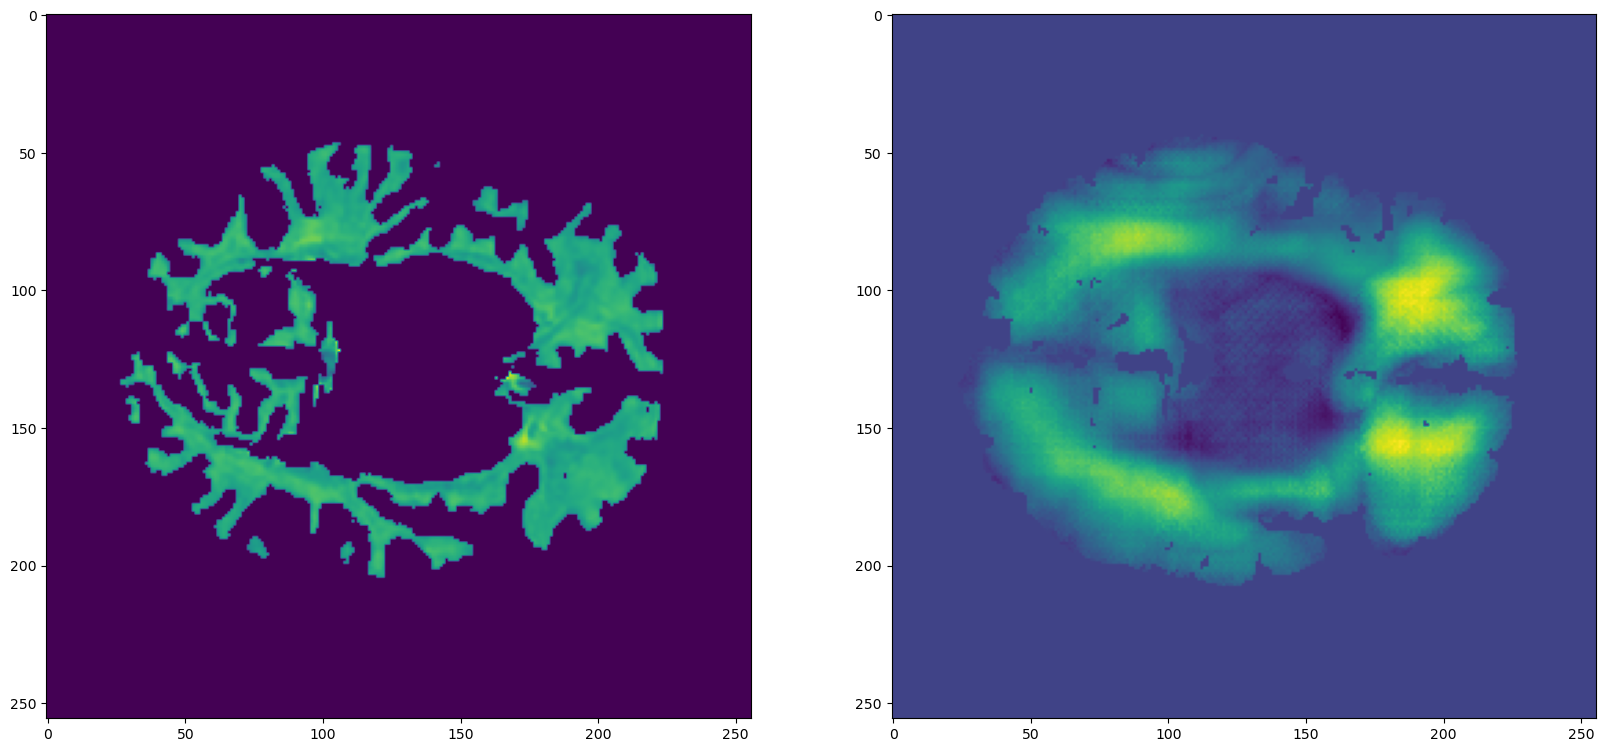

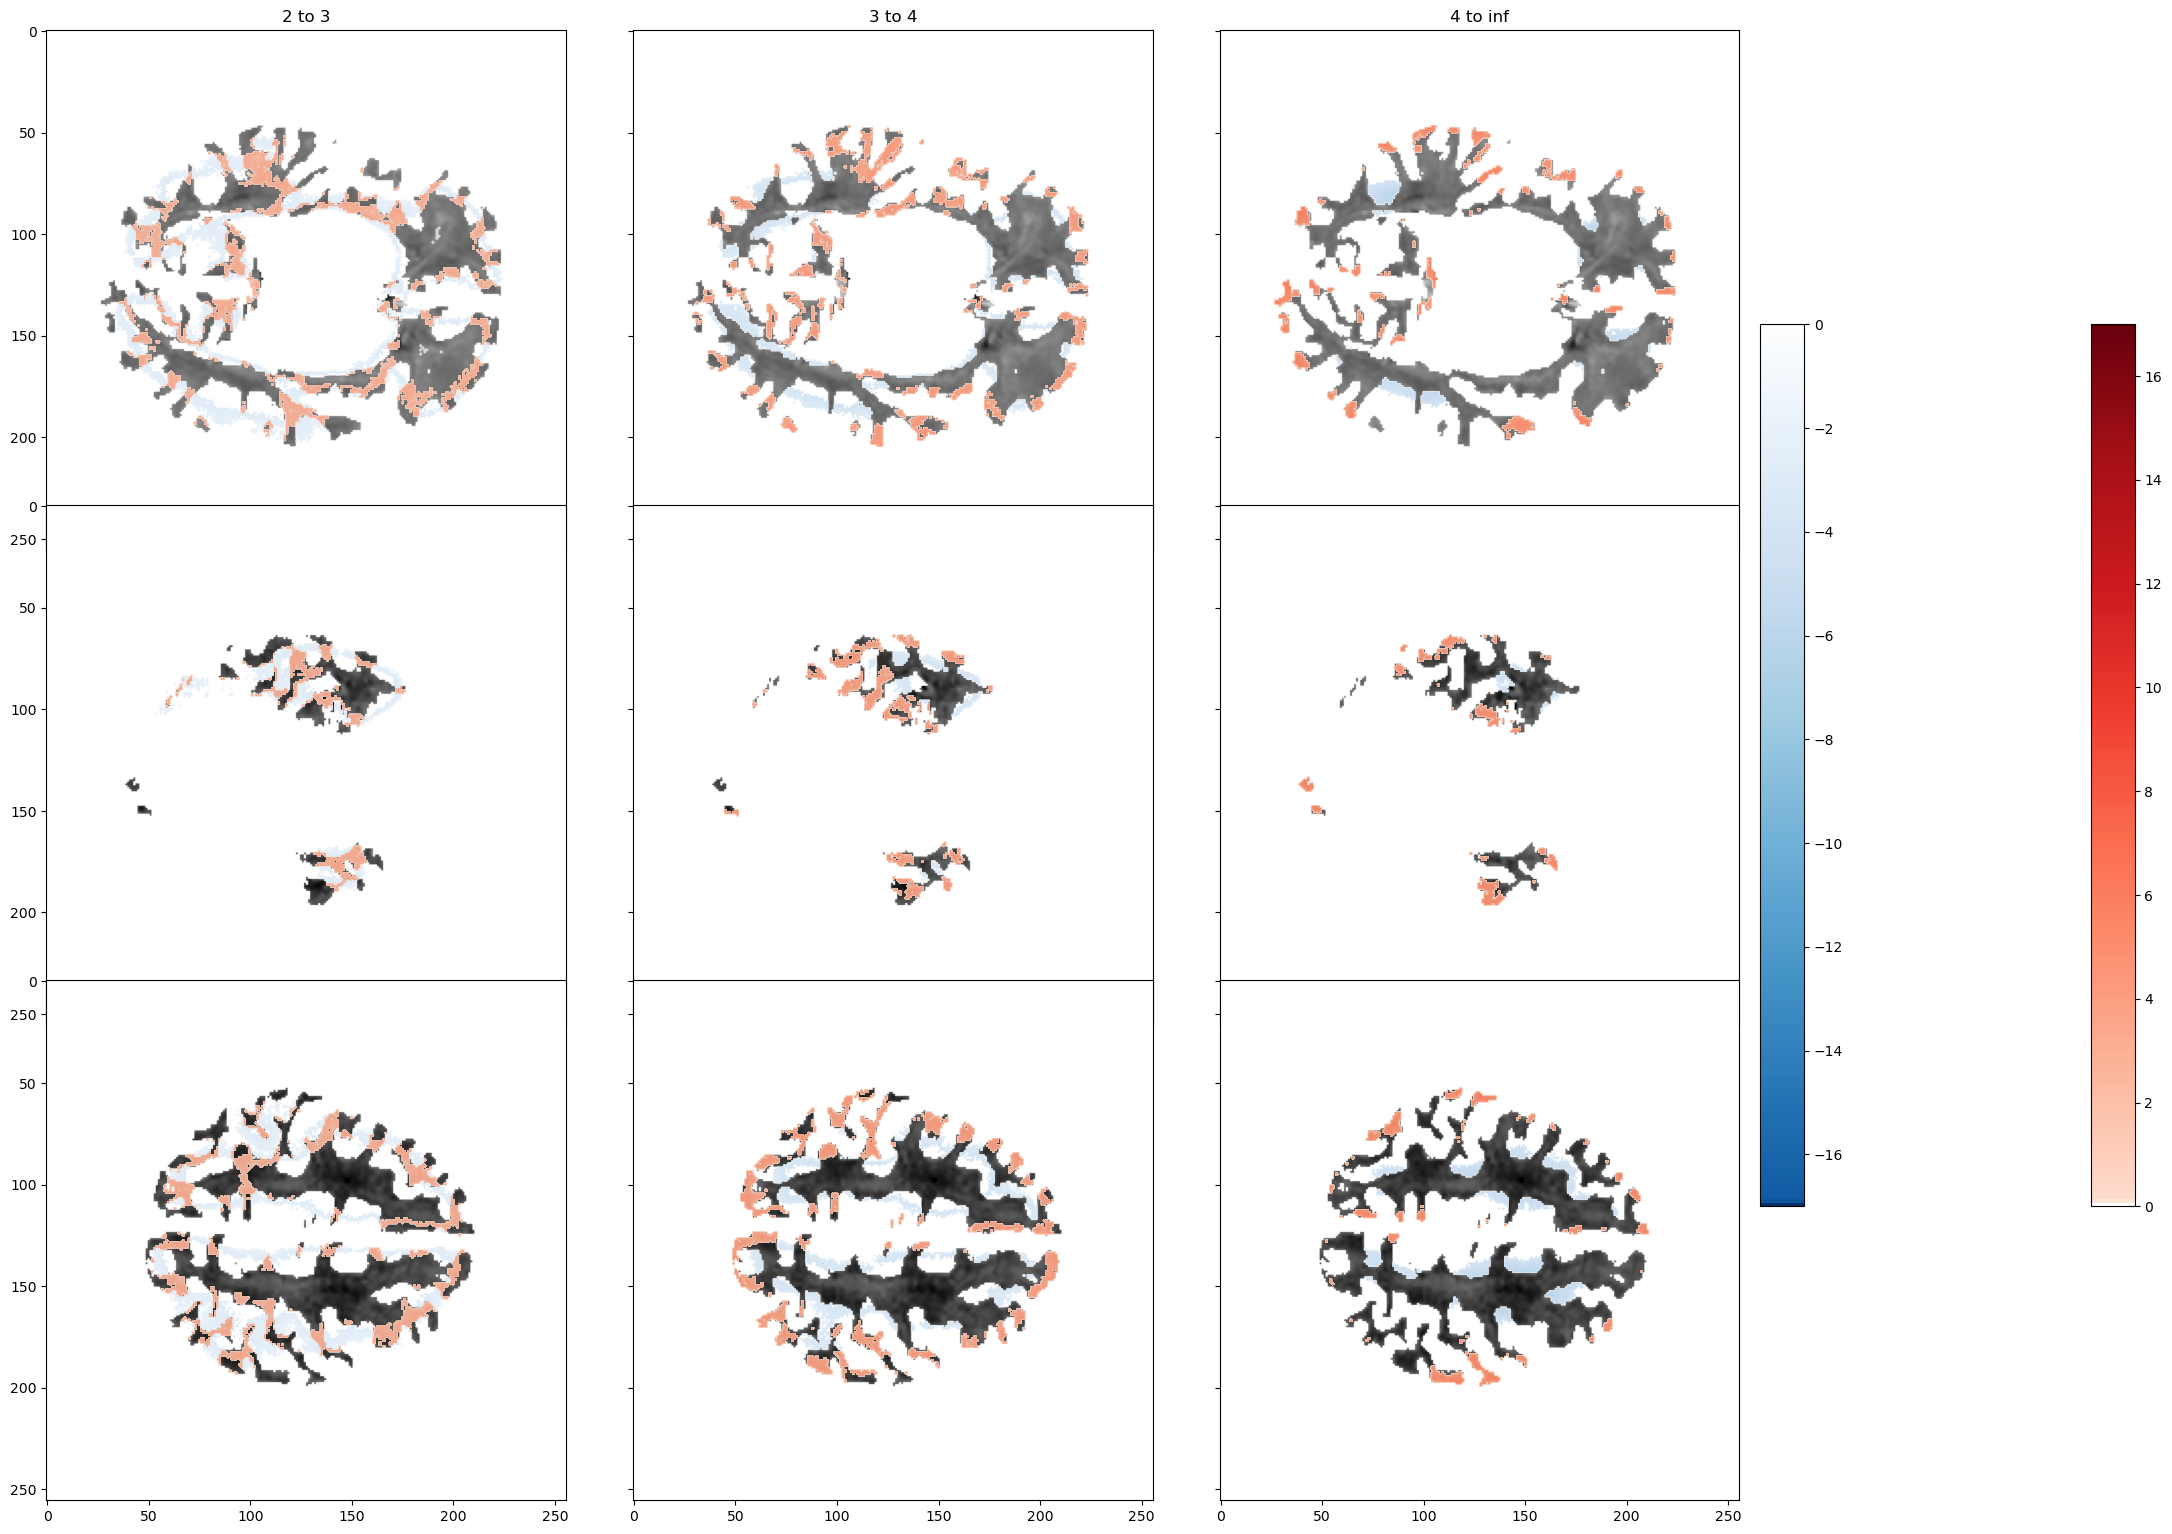

In [20]:
index = 0
x, y = train[index]
residual = x - y
residual = torch.Tensor(np.reshape(residual, (1, 1, 256, 256, 256))).cuda(device)
output = model(residual)

og = np.reshape(x, (256, 256, 256))
coarse = np.reshape(y, (256, 256, 256))
fine = np.reshape(output.cpu().detach().numpy(), (256, 256, 256))
# pred = np.sum(pred, axis=0)
# og = np.sum(og, axis=0)
# coarse = np.sum(coarse, axis=0)
# fine = np.sum(fine, axis=0)

s = 128

# exclude csf and background
seg = train_segments[index]
seg_slice = exclude_segments(seg[:,:,s], [1, 4])
og_slc = og[:,:,s] * seg_slice
fine_slc = fine[:,:,s] * seg_slice

(score, diff) = ssim(og_slc, fine_slc, full=True)
print("SSIM: ", score)


fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(og_slc)
ax[1].imshow(fine_slc)

full_seg = exclude_segments(seg, [1, 4])
viz_slices(og * full_seg, fine * full_seg)

### Visualize Val Results

SSIM:  0.7229726712943031


D:\school\research\code\explore_again\modeling\vae\visualization.py:152: UserWarning: Trying to register the cmap 'above_mean2' which already exists.
  plt.register_cmap(cmap=map_object)
D:\school\research\code\explore_again\modeling\vae\visualization.py:159: UserWarning: Trying to register the cmap 'below_mean2' which already exists.
  plt.register_cmap(cmap=map_object)


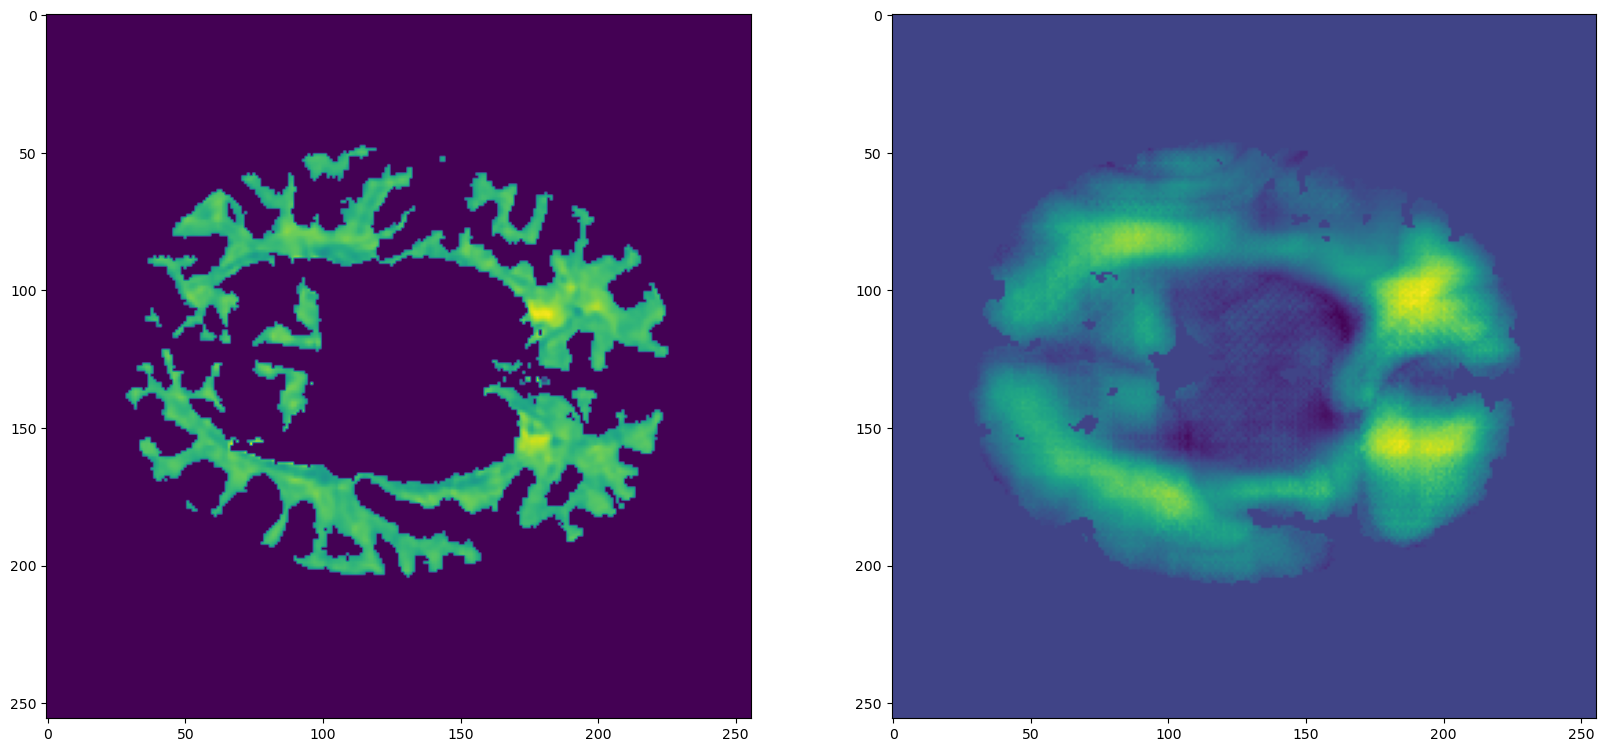

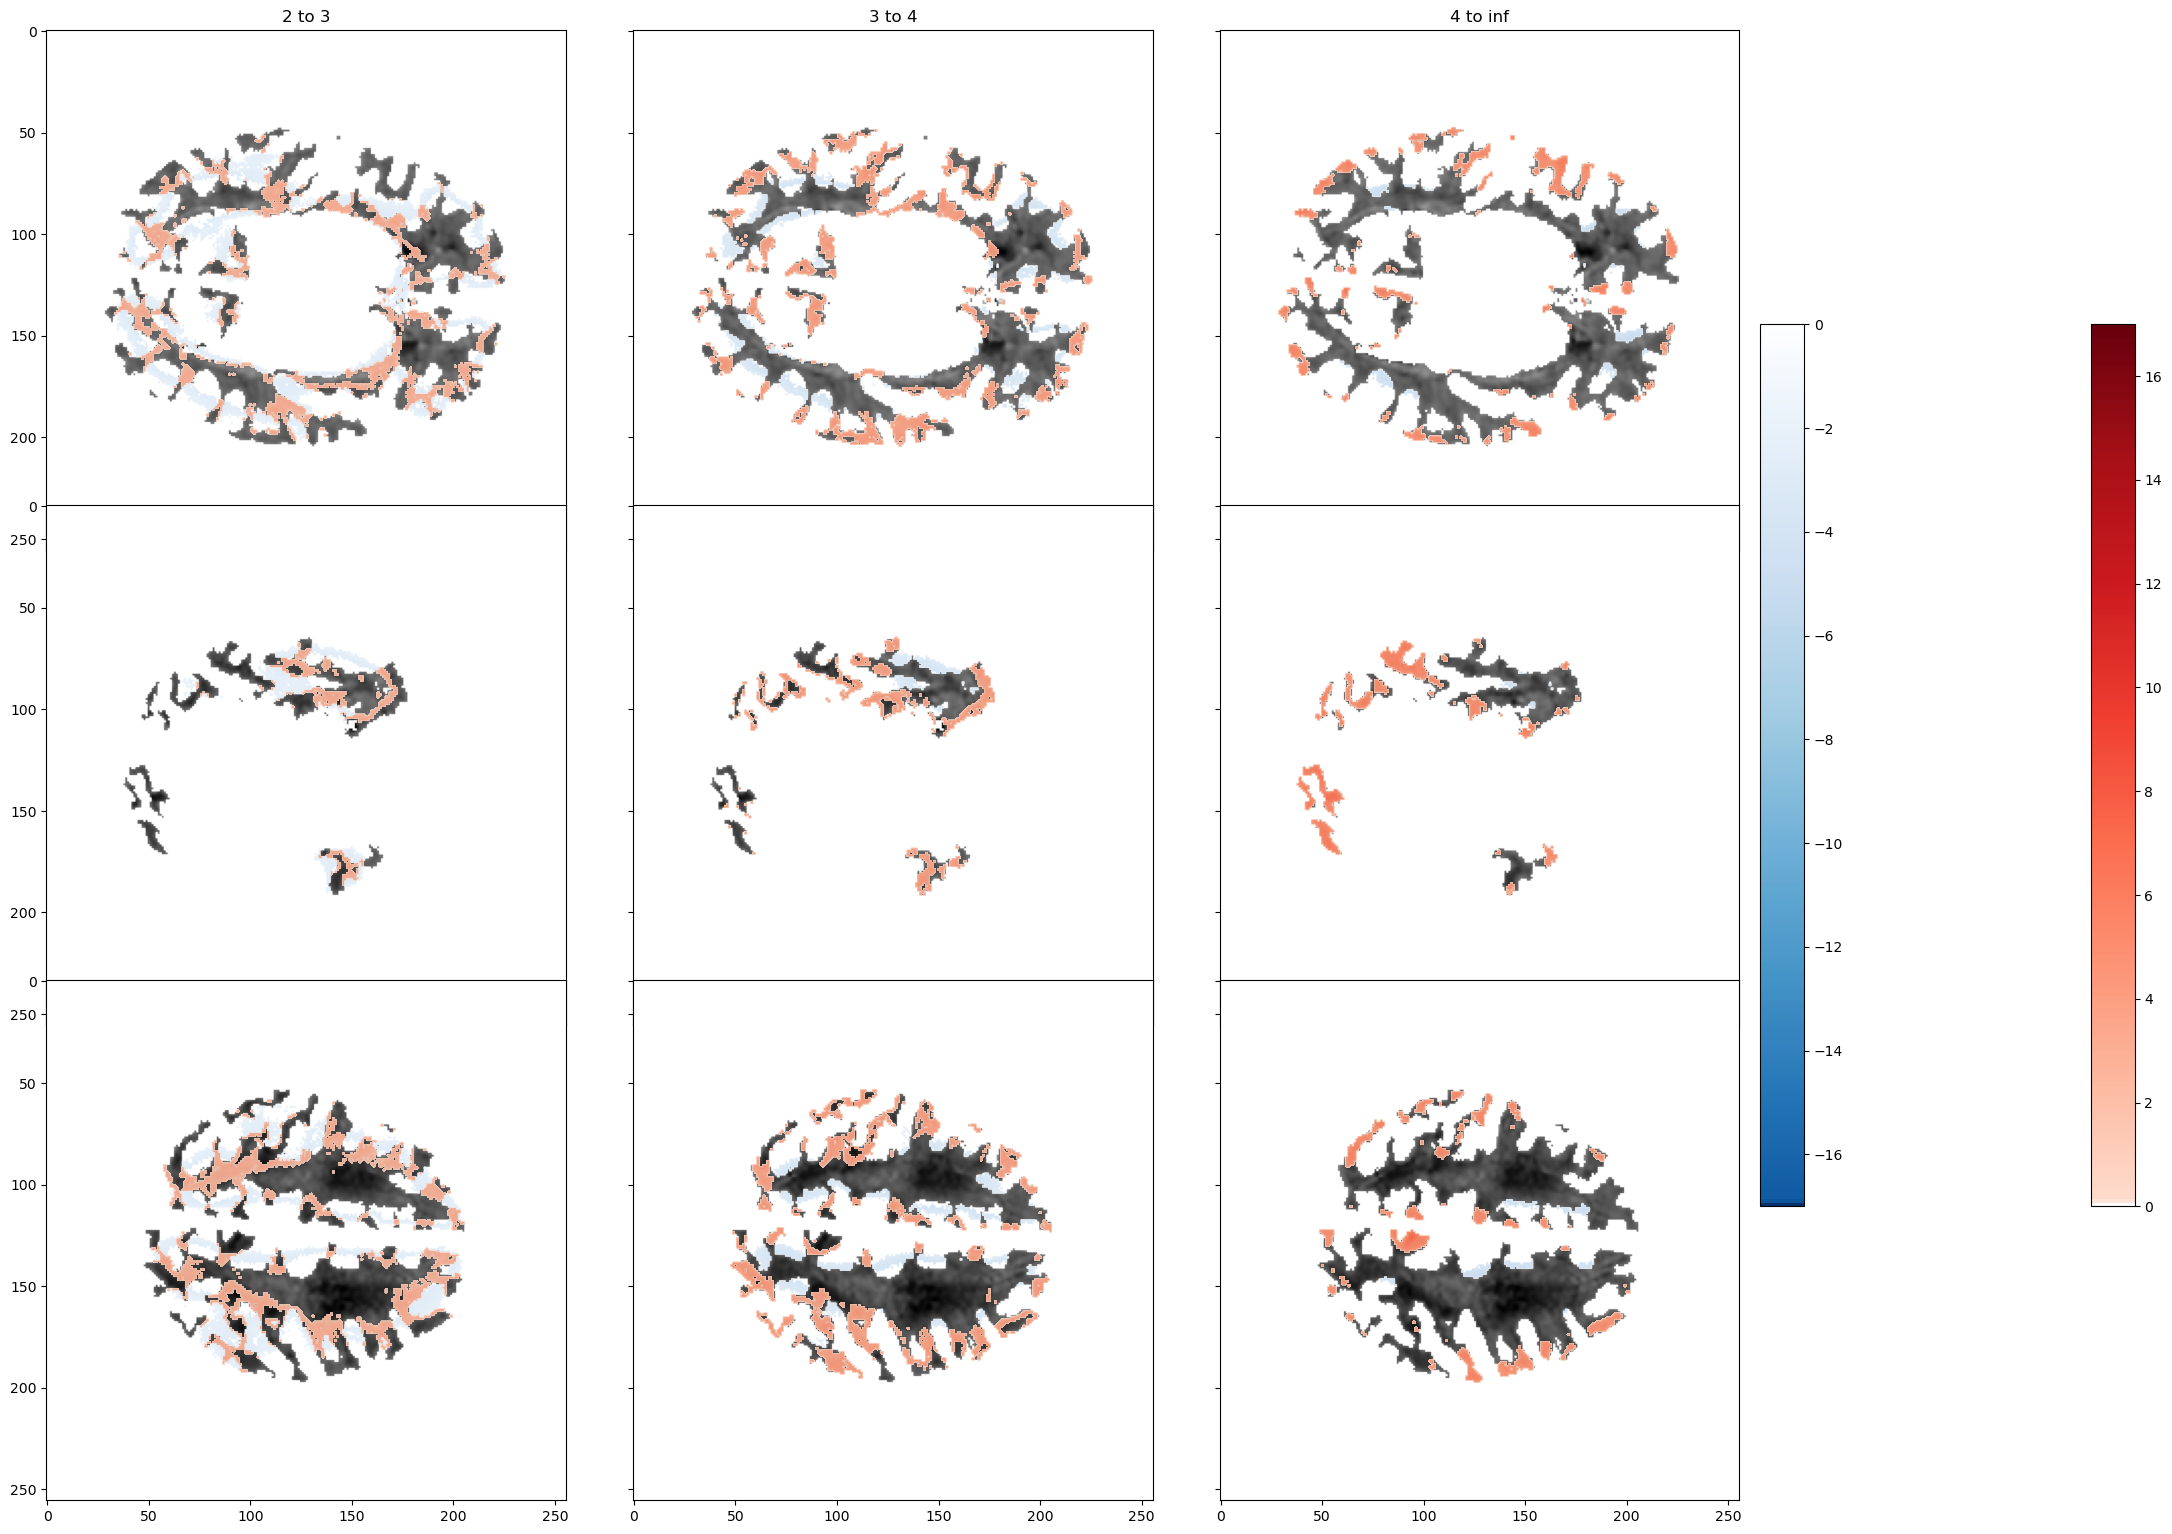

In [21]:
index = 10
x, y = val[index]
residual = x - y
residual = torch.Tensor(np.reshape(residual, (1, 1, 256, 256, 256))).cuda(device)
output = model(residual)

og = np.reshape(x, (256, 256, 256))
coarse = np.reshape(y, (256, 256, 256))
fine = np.reshape(output.cpu().detach().numpy(), (256, 256, 256))
# pred = np.sum(pred, axis=0)
# og = np.sum(og, axis=0)
# coarse = np.sum(coarse, axis=0)
# fine = np.sum(fine, axis=0)

s = 128

# exclude csf and background
seg = val_segments[index]
seg_slice = exclude_segments(seg[:,:,s], [1, 4])
og_slc = og[:,:,s] * seg_slice
fine_slc = fine[:,:,s] * seg_slice

(score, diff) = ssim(og_slc, fine_slc, full=True)
print("SSIM: ", score)


fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(og_slc)
ax[1].imshow(fine_slc)

full_seg = exclude_segments(seg, [1, 4])
viz_slices(og * full_seg, fine * full_seg)

### Visualize Test Results

SSIM:  0.7491948256076334


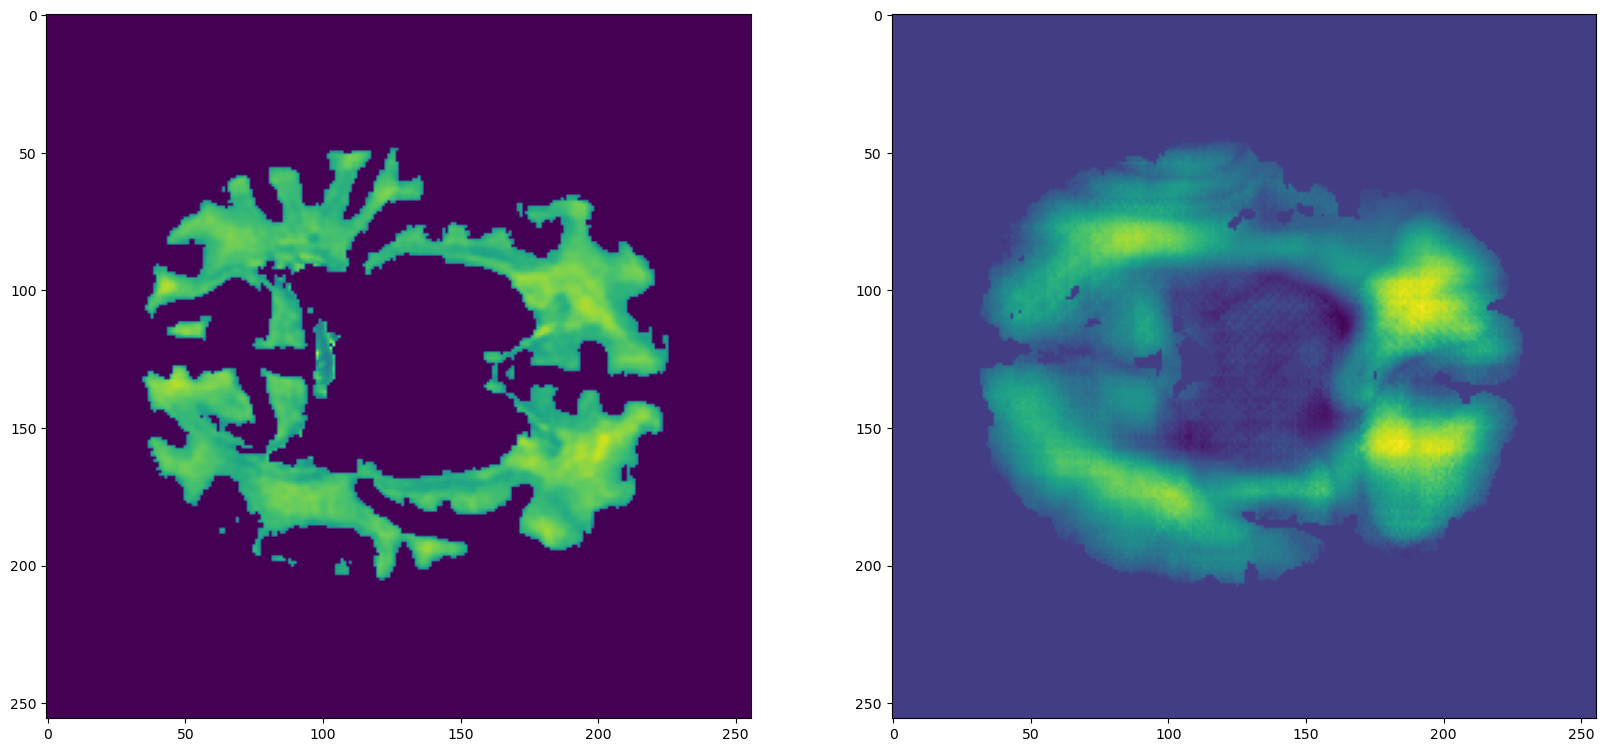

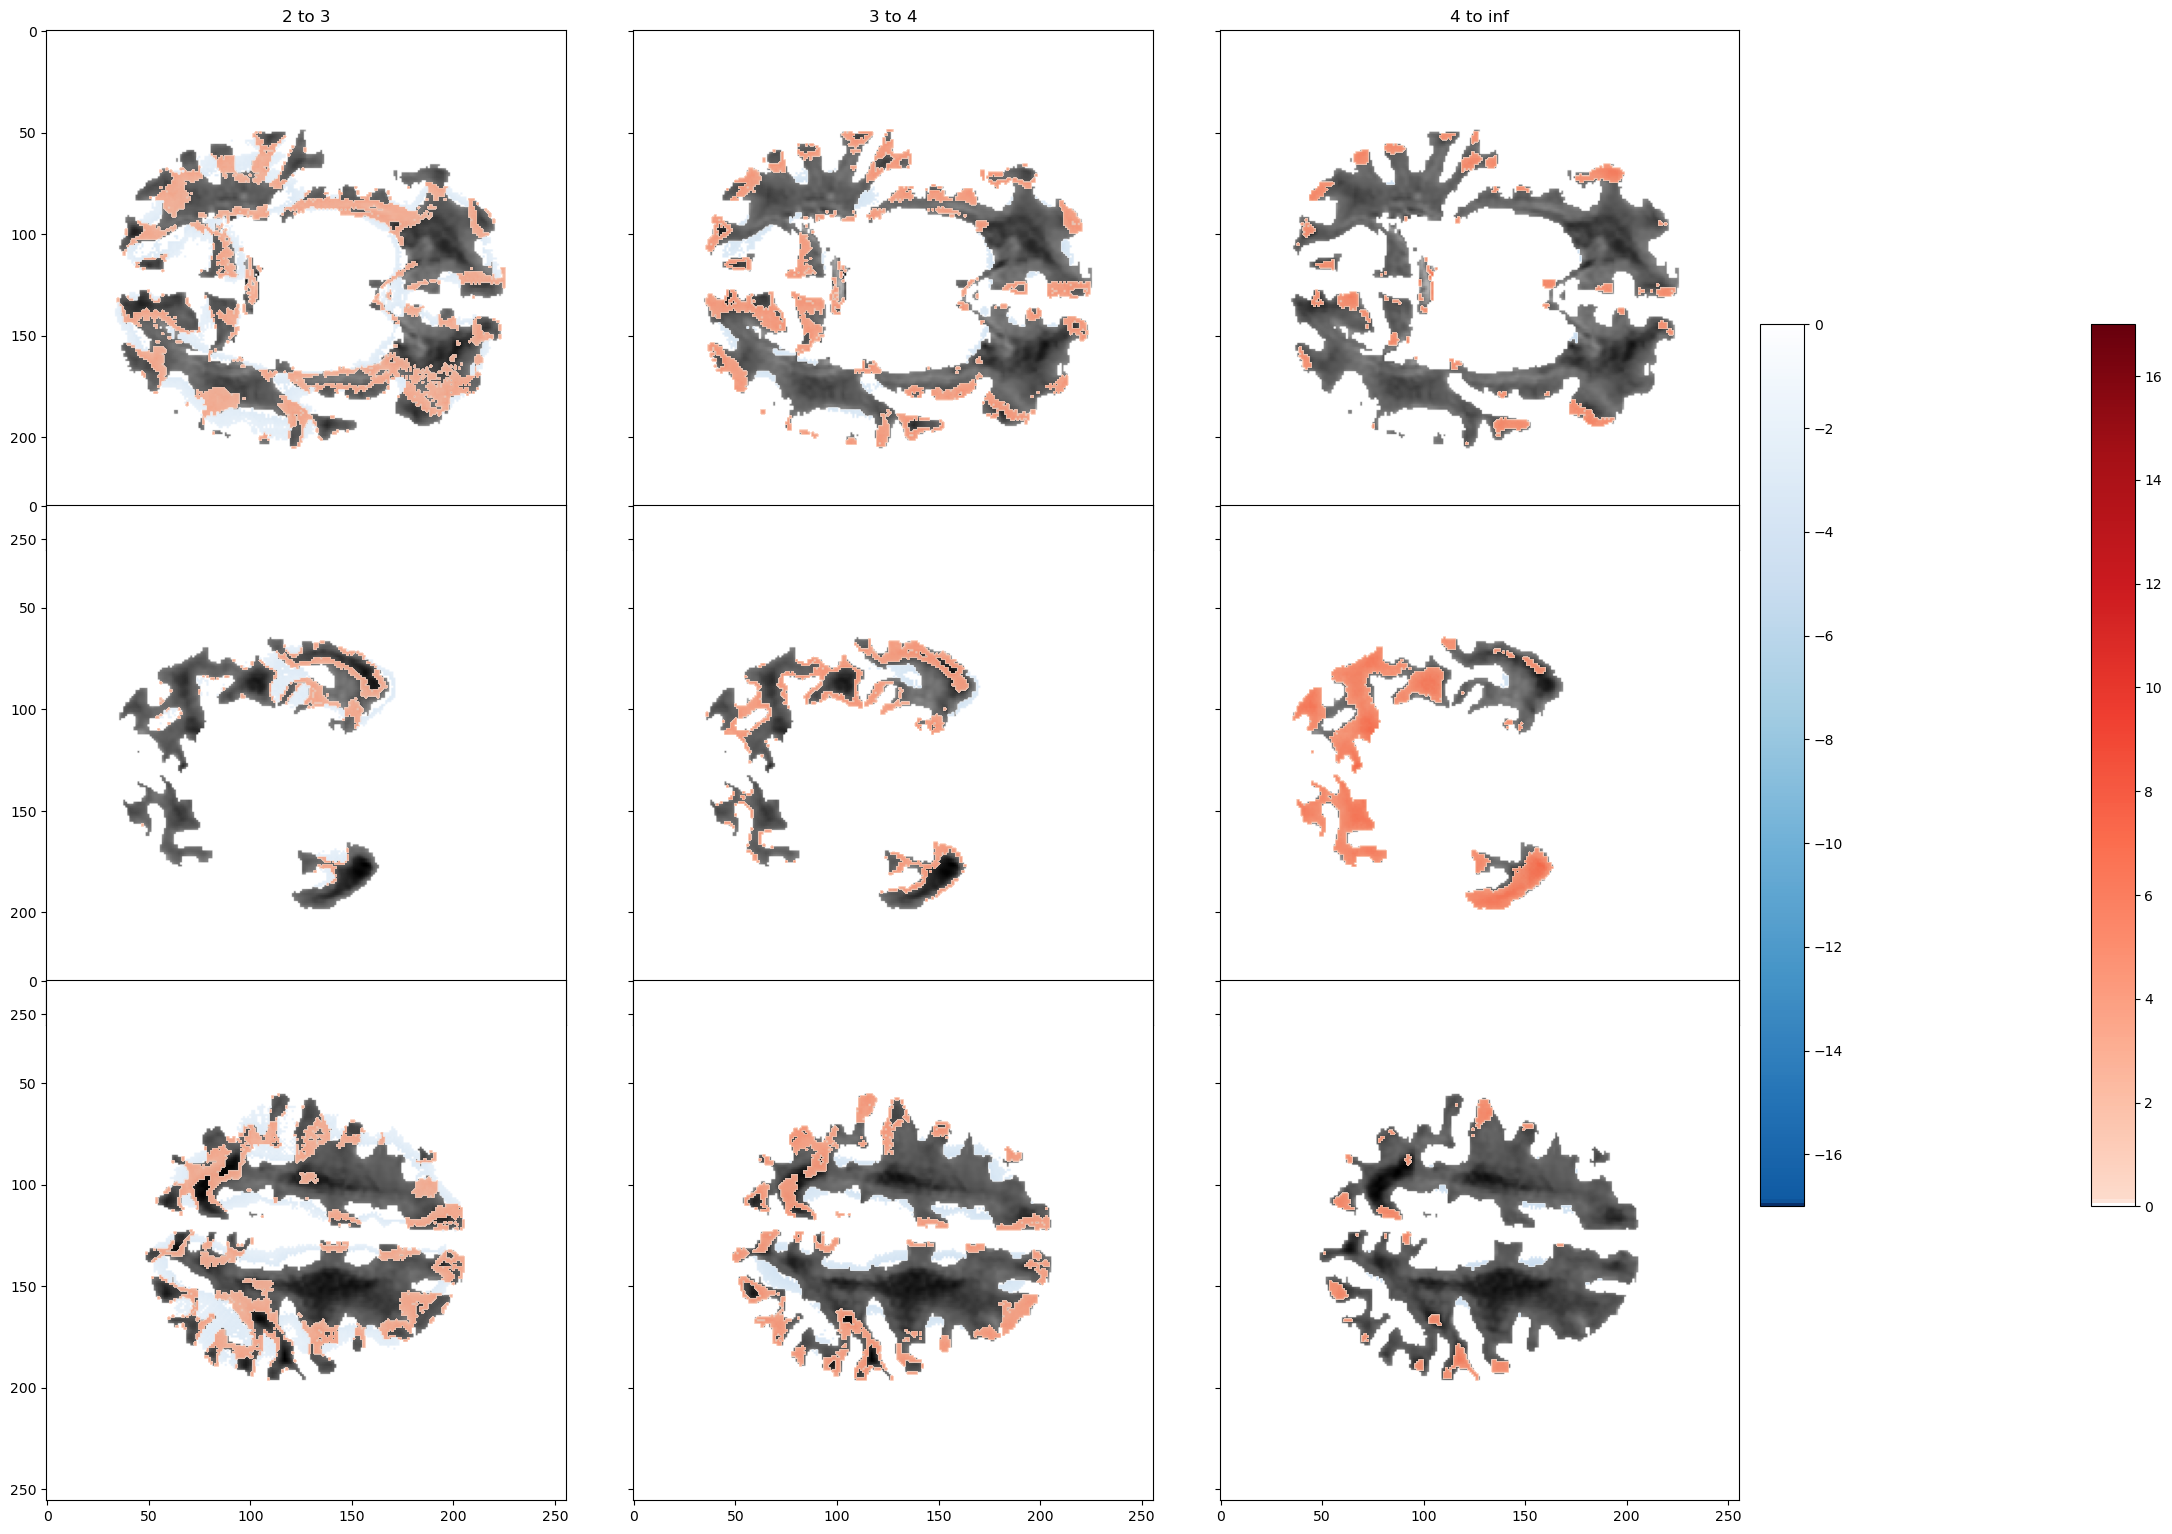

In [22]:
index = 25
x, y = test[index]
residual = x - y
residual = torch.Tensor(np.reshape(residual, (1, 1, 256, 256, 256))).cuda(device)
output = model(residual)

og = np.reshape(x, (256, 256, 256))
coarse = np.reshape(y, (256, 256, 256))
fine = np.reshape(output.cpu().detach().numpy(), (256, 256, 256))
# pred = np.sum(pred, axis=0)
# og = np.sum(og, axis=0)
# coarse = np.sum(coarse, axis=0)
# fine = np.sum(fine, axis=0)

s = 128

# exclude csf and background
seg = test_segments[index]
seg_slice = exclude_segments(seg[:,:,s], [1, 4])
og_slc = og[:,:,s] * seg_slice
fine_slc = fine[:,:,s] * seg_slice

(score, diff) = ssim(og_slc, fine_slc, full=True)
print("SSIM: ", score)


fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(og_slc)
ax[1].imshow(fine_slc)

full_seg = exclude_segments(seg, [1, 4])
viz_slices(og * full_seg, fine * full_seg)

In [37]:
x.reshape((9, 256, 256, 256)).detach().cpu().numpy().shape

(9, 256, 256, 256)

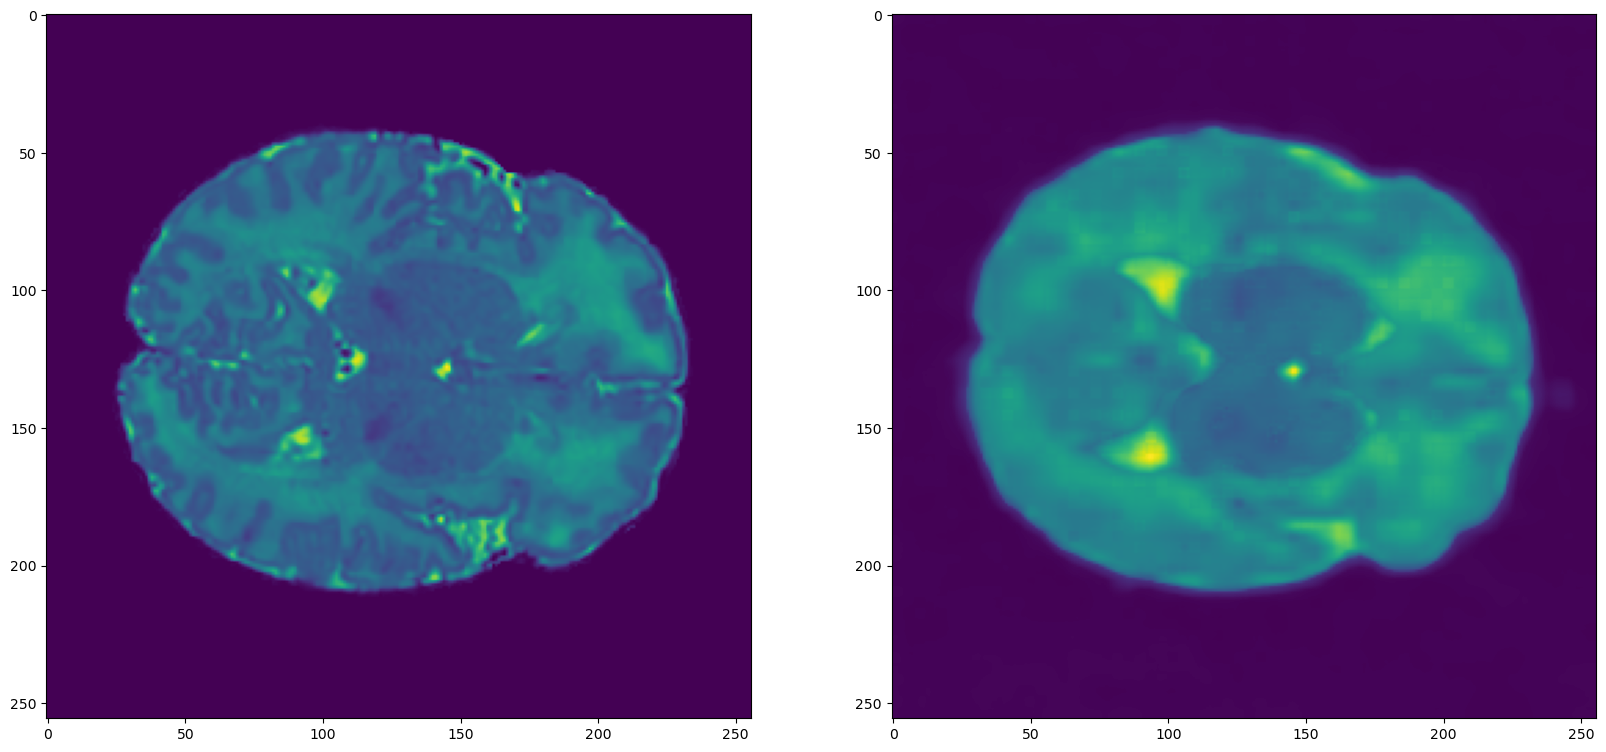

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))

ax[0].imshow(np.sum(x.reshape((9, 256, 256, 256)).detach().cpu().numpy(), axis=0)[:,:,128])
ax[1].imshow(np.sum(y.reshape((9, 256, 256, 256)).detach().cpu().numpy(), axis=0)[:,:,128])